# Seq2Seq with Attention

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F45345

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import dataset with 70K pairs of commands

In [2]:
source = open('data/commands_source_en_70k.txt', encoding='UTF-8').read().strip().split('\n')  
target = open('data/commands_target_en_70k.txt', encoding='UTF-8').read().strip().split('\n')   

Add extra number pairs (1k). PS: using 10K will introduce quite a lot noise to dictionary

In [3]:
# add numbers
source_num = open('data/nums_source_en_10k.txt', encoding='UTF-8').read().strip().split('\n')  
target_num = open('data/nums_target_en_10k.txt', encoding='UTF-8').read().strip().split('\n') 
source.extend(source_num[:1000])
target.extend(target_num[:1000])

In [4]:
import pandas as pd
data = pd.DataFrame(list(zip(target, source)), columns=["src", "tgt"])
data.head()

,src,tgt
0,is it warm in algund at two fifty five,is it warm in Algund at 02:55
1,how warm will it get,how warm will it get
2,how hot is it,how hot is it
3,how warm will it get at nineteen fifty eight,how warm will it get at 19:58
4,I would like to know how cold it is,I would like to know how cold it is


In [5]:
li = random.choices(data.src.unique(), k = int(len(data.src.unique()) *0.1 ))
train_df = data[~data.src.isin(li)]
test_df = data[data.src.isin(li)]

print("test size: {} unique sentences".format(len(li)))
print("train size: {} sample senteces (with duplication)".format(sum(~data.src.isin(li))) )

test size: 3155 unique sentences
train size: 63945 sample senteces (with duplication)


In [9]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [10]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([a-zA-Z]+)[\:\-]", r"\1 ", s)  # colun:dsfa -> colun dsfa
    s = re.sub(r"(\d+)[\:](\d+)", r"\1 : \2", s) # 15:30 -> 15:30
    s = re.sub(r"([\.\+])", r" \1 ", s)
    s = re.sub(r"([\-])", r" ", s)
#     s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s

In [11]:
def readLangs(lang1, lang2, lang_class=Lang):
    print("Reading lines...")

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s), normalizeString(t) ]for s, t in list(zip(lang1, lang2))] 

    input_lang = lang_class('src')
    output_lang = lang_class('tgt')

    return input_lang, output_lang, pairs

In [12]:
def prepareData(lang1, lang2, lang_class=Lang):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, lang_class)
    print("Read %s sentence pairs" % len(pairs))
#     pairs = filterPairs(pairs)
#     print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(train_df.src.tolist(), train_df.tgt.tolist())
print(random.choice(pairs))

Reading lines...
Read 63945 sentence pairs
Counting words...
Counted words:
src 5940
tgt 7064
['is it raining', 'is it raining']


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=30):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [17]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=30):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [20]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [21]:
def evaluate(encoder, decoder, sentence, max_length=30):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 42s (- 32m 26s) (3000 5%) 3.3156
3m 25s (- 30m 52s) (6000 10%) 1.6900
5m 10s (- 29m 19s) (9000 15%) 1.2631
6m 57s (- 27m 48s) (12000 20%) 1.1042
8m 43s (- 26m 11s) (15000 25%) 0.9000
10m 30s (- 24m 31s) (18000 30%) 0.8704
12m 17s (- 22m 49s) (21000 35%) 0.7764
14m 2s (- 21m 4s) (24000 40%) 0.7511
15m 50s (- 19m 21s) (27000 45%) 0.7025
17m 38s (- 17m 38s) (30000 50%) 0.6786
19m 24s (- 15m 52s) (33000 55%) 0.6357
21m 12s (- 14m 8s) (36000 60%) 0.6574
23m 0s (- 12m 23s) (39000 65%) 0.5992
24m 47s (- 10m 37s) (42000 70%) 0.5863
26m 33s (- 8m 51s) (45000 75%) 0.6313
28m 19s (- 7m 4s) (48000 80%) 0.5576
30m 4s (- 5m 18s) (51000 85%) 0.5224
31m 50s (- 3m 32s) (54000 90%) 0.6309
33m 36s (- 1m 46s) (57000 95%) 0.7700
35m 22s (- 0m 0s) (60000 100%) 0.5671


<Figure size 432x288 with 0 Axes>

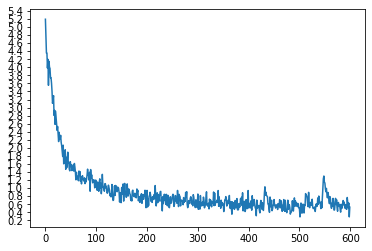

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 60000, print_every=3000, learning_rate=0.01)

In [27]:
# evaluate in training set
evaluateRandomly(encoder1, attn_decoder1)

> do you think it will rain at nineteen eighteen
= do you think it will rain at 19 : 18
< do you think it will rain at 19 : 19 <EOS>

> do i need an umbrella in biel on sixteenth october
= do i need an umbrella in biel on 16 . 10
< do i need an umbrella in biel on 16 . 10 <EOS>

> change the radio station please
= change the radio station please
< change the radio station please <EOS>

> security camera on in the tv room
= security camera on in the tv room
< camera on on in the tv room <EOS>

> should i get my umbrella
= should i get my umbrella
< should i get my umbrella <EOS>

> i want to turn on device hue go one
= i want to turn on device hue go 1
< i want to turn on device hue go 1 <EOS>

> turn on cameras in the home office
= turn on cameras in the home office
< turn on cameras in the home office <EOS>

> i would like to know how cold it is in algund
= i would like to know how cold it is in algund
< i would like to know how cold it is in algund <EOS>

> would you please change th

In [23]:
# evaluate in validation set
from jiwer import wer
from tqdm import tqdm 

def evaluateWER(encoder, decoder, n=10):
    WER = 0
    size = 0
    for test_pair in tqdm(test_pairs):
        try:
            output_words, attentions = evaluate(encoder, decoder, test_pair[0])
            output_sentence = ' '.join(output_words[:-1])
            WER += wer(test_pair[1], output_sentence)
            size += 1
        except:
            pass
    print("WER: {}".format(WER/ size))
    for i in range(n):
        try:
            test_pair = random.choice(test_pairs)
            print('>', test_pair[0])
            print('=', test_pair[1])
            output_words, attentions = evaluate(encoder, decoder, test_pair[0])
            output_sentence = ' '.join(output_words)
            print('<', output_sentence)
            print('')
        except:
            pass
        
wer_base = wer(test_df.drop_duplicates().src.tolist(), test_df.drop_duplicates().tgt.tolist())
print("WER_base: {}".format(wer_base))
test_pairs = [[normalizeString(s), normalizeString(t) ]for s, t in list(zip(test_df.drop_duplicates().src, test_df.drop_duplicates().tgt))] 
evaluateWER(encoder1, attn_decoder1, n=20)

  0%|          | 0/3072 [00:00<?, ?it/s]

WER_base: 0.3243918628714224


100%|██████████| 3072/3072 [00:38<00:00, 79.89it/s] 


WER: 0.2235407253357953
> i want to know how hot it is in tremosine from eleven sixteen to ten twenty one
= i want to know how hot it is in tremosine from 11 : 16 to 10 : 21
< i want to know how hot it is in tremosine from 16 : 16 to 21 : 16 <EOS>

> how much will it rain on fourteenth june in saint leonhard in passeier
= how much will it rain on 14 . 6 in saint leonhard in passeier
< how much will it rain on 14 . 6 in saint leonhard in passeier <EOS>

> please switch to rtl one hundred and two five
= please switch to rtl 102  .  5
< please switch to 105 - - 02 2 <EOS>

> turn on the irobot bulb in my home office
= turn on the irobot bulb in my home office
< turn on the my bulb in my home office <EOS>

> the rainfall on twenty eighth september
= the rainfall on 28 . 9
< the rainfall on 28 . 9 <EOS>

> put on canal plus decale please
= put on canal+ decale please
< put on canal plus - please <EOS>

> how warm will it get at twenty two nineteen
= how warm will it get at 22 : 19
< how war

input = is it going to be nice outside at seventeen fifteen in milan
output = is it going to be nice outside at 17 : 17 in milan <EOS>


<ipython-input-25-8aeba70aa22f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-25-8aeba70aa22f>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


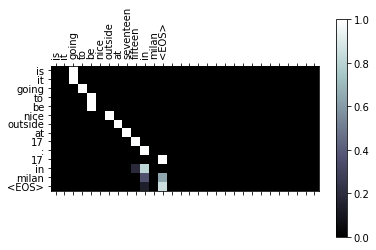

input = tell me something about real betis sevilla
output = tell me something about night  <EOS>


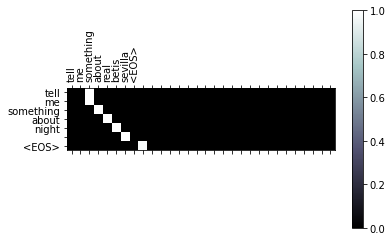

input = is it raining on fifteenth september
output = is it raining on 15 . 9 <EOS>


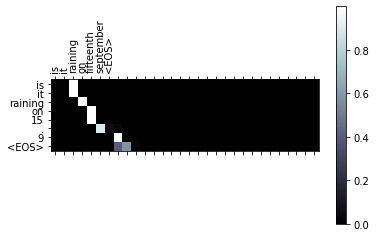

input = four hundred and twenty eight
output = 288 <EOS>


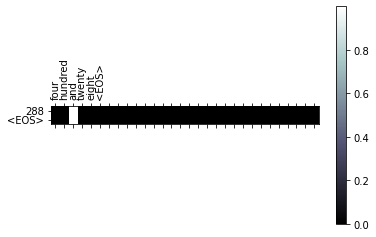

input = is it raining in plateau from seven twenty five to three fifteen
output = is it raining in plateau from 23 : 17 to 03 : 17 <EOS>


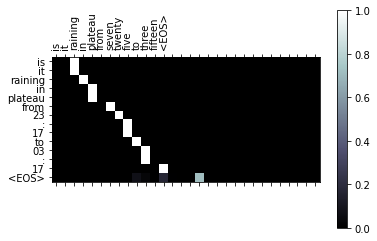

In [25]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("is it going to be nice outside at seventeen fifteen in milan")
evaluateAndShowAttention("tell me something about real betis sevilla")
evaluateAndShowAttention("is it raining on fifteenth september")
evaluateAndShowAttention("four hundred and twenty eight")
evaluateAndShowAttention("is it raining in plateau from seven twenty five to three fifteen")

## GloVe

In [30]:
import bcolz
import pickle
# words = []
# idx = 0
# word2idx = {}
glove_path = "/home/zhechensu/glove/glove.6B.50d.txt"
rootdir = f'/home/zhechensu/glove/glove.6B/'
# vectors = bcolz.carray(np.zeros(1), rootdir=rootdir + '6B.50.dat', mode='w')

# with open(glove_path, 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         words.append(word)
#         word2idx[word] = idx
#         idx += 1
#         vect = np.array(line[1:]).astype(np.float)
#         vectors.append(vect)
     
# vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir= rootdir + '6B.50.dat', mode='w')
# vectors.flush()
# pickle.dump(words, open(rootdir + '6B.50_words.pkl', 'wb'))
# pickle.dump(word2idx, open(rootdir + '6B.50_idx.pkl', 'wb'))

In [31]:
# Load Glove Vectors
vectors = bcolz.open(rootdir + '6B.50.dat')[:]
words = pickle.load(open(rootdir + '6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(rootdir + '6B.50_idx.pkl', 'rb'))
 
glove = {w: vectors[word2idx[w]] for w in words}

In [32]:
# for moving 'sos' token at index 0 and 'eos' token at index 1

sos_index = word2idx['sos']
eos_index = word2idx['eos']
sos_swap_word = words[0]
eos_swap_word = words[1]
 
words[0], words[sos_index] = words[sos_index], words[0]
words[1], words[eos_index] = words[eos_index], words[1]
word2idx[sos_swap_word], word2idx['sos'] = word2idx['sos'], word2idx[sos_swap_word]
word2idx[eos_swap_word], word2idx['eos'] = word2idx['eos'], word2idx[eos_swap_word]


In [33]:
# Sort word2idx
import operator
word2idx = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}


In [34]:
class LangGlove:
    def __init__(self, name):
        self.name = name
        self.word2index = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}
        self.word2count = { word : 1 for word in words }
        self.index2word = { i : word for word, i in word2idx.items() }
        self.n_words = 400001
 
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
 
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [35]:
input_lang, output_lang, pairs = prepareData(train_df.src.tolist(), train_df.tgt.tolist(), LangGlove)
print(random.choice(pairs))

Reading lines...
Read 63945 sentence pairs
Counting words...
Counted words:
src 400792
tgt 401024
['change radio station', 'change radio station']


16m 47s (- 318m 54s) (3000 5%) 4.2590
34m 29s (- 310m 29s) (6000 10%) 2.3016
52m 26s (- 297m 8s) (9000 15%) 1.7287
70m 34s (- 282m 19s) (12000 20%) 1.4103
88m 46s (- 266m 18s) (15000 25%) 1.2898
106m 56s (- 249m 31s) (18000 30%) 1.1217
125m 21s (- 232m 49s) (21000 35%) 1.0638
143m 34s (- 215m 21s) (24000 40%) 1.0004
161m 48s (- 197m 45s) (27000 45%) 0.9114
179m 58s (- 179m 58s) (30000 50%) 0.9374
198m 9s (- 162m 7s) (33000 55%) 0.8319
216m 29s (- 144m 19s) (36000 60%) 0.7930
234m 36s (- 126m 19s) (39000 65%) 0.7657
252m 54s (- 108m 23s) (42000 70%) 0.7559
271m 12s (- 90m 24s) (45000 75%) 0.7139
289m 46s (- 72m 26s) (48000 80%) 0.7102
308m 8s (- 54m 22s) (51000 85%) 0.7126
326m 37s (- 36m 17s) (54000 90%) 0.6842
344m 53s (- 18m 9s) (57000 95%) 0.6298
363m 19s (- 0m 0s) (60000 100%) 0.6678


<Figure size 432x288 with 0 Axes>

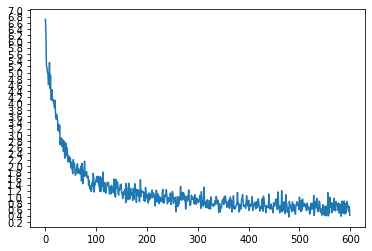

In [58]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 60000, print_every=3000, learning_rate=0.01)

In [59]:
evaluateWER(encoder1, attn_decoder1, n=20)

100%|██████████| 3072/3072 [02:53<00:00, 17.66it/s]


WER: 0.20611833088994097
> switch to folx tv
= switch to folx  .  tv
< switch to tv tv tv <EOS>

> switch to karusel int
= switch to karusel int . 
< switch to rai monde <EOS>

> show me standoff
= show me standoff
< show me <EOS>

> which temperatures can we expect in munstertal black forest
= which temperatures can we expect in munstertal (black forest)
< which temperatures can we expect in munstertal (black forest) <EOS>

> could you please change the radio station to rsi three
= could you please change the radio station to rsi 3
< could you please change the radio station to 23 3 <EOS>

> is it going to be hot in saint leonhard in passeier at one forty seven
= is it going to be hot in saint leonhard in passeier at 01 : 47
< is it going to be hot in saint leonhard in passeier at 01 : 47 <EOS>

> i want to know if it will rain on ninth december in constance
= i want to know if it will rain on 9 . 12 in constance
< i want to know if it will rain on 9 . 12 in constance <EOS>

> i am lo

input = is it going to be nice outside at seventeen fifteen in milan
output = is it going to be nice outside at 17 : 15 in milan <EOS>


<ipython-input-38-54521568c49a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-38-54521568c49a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


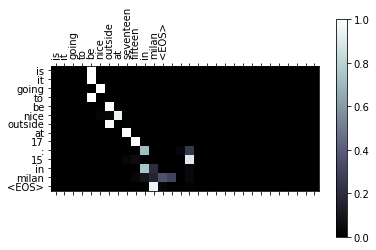

input = tell me something about real betis sevilla
output = tell me something about patrick j <EOS>


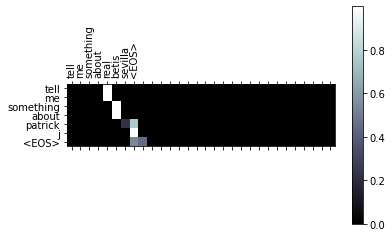

input = is it raining on fifteenth september
output = is it raining on 15 . 9 <EOS>


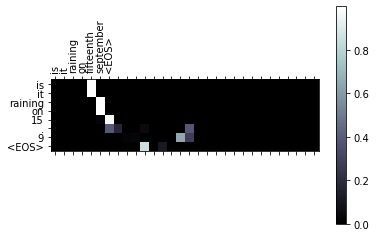

input = four hundred and twenty eight
output = 28 <EOS>


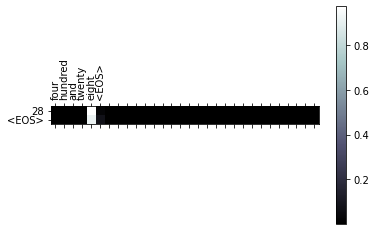

input = is it raining in plateau from seven twenty five to three fifteen
output = is it raining in plateau from 15 : 52 to 03 : 15 <EOS>


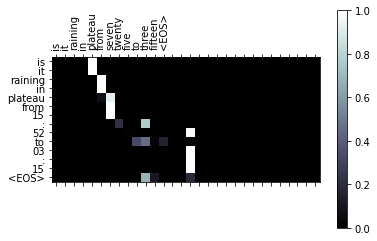

In [38]:
import torch.nn.functional as F
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("is it going to be nice outside at seventeen fifteen in milan")
evaluateAndShowAttention("tell me something about real betis sevilla")
evaluateAndShowAttention("is it raining on fifteenth september")
evaluateAndShowAttention("four hundred and twenty eight")
evaluateAndShowAttention("is it raining in plateau from seven twenty five to three fifteen")
# evaluateAndShowAttention("i am looking for star wars  revenge of the sit")

In [26]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
 
def load_variable(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

# save_variable(encoder1, 'models/s2s_60k+1k+glove_encoder.pkl') 
# save_variable(attn_decoder1, 'models/s2s_60k+1k+glove_decoder.pkl') 

Evaluation for 70K model

In [23]:
name = '60k+1k+glove' #{'70k', '60k+1k', '60k+1k+glove'}
encoder1 = load_variable('models/s2s_{}_encoder.pkl'.format(name))
attn_decoder1 = load_variable('models/s2s_{}_decoder.pkl'.format(name))
# evaluateRandomly(a, b)